In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
# task = 'V11L12-038_A1_rand'
# task = 'V11L12-038_A1_half'
task = 'neuro'
fs = "hvg"
file_path = f"/lustre/groups/ml01/workspace/eirini/pipeline/data/reports/{task}/merged_results.tsv"
df_full = df = pd.read_csv(file_path, sep='\t')
df = df_full[df_full["featsel"] == fs].copy()
sns.set_theme(style="whitegrid", palette="pastel")


Top 5 Best performers per metric

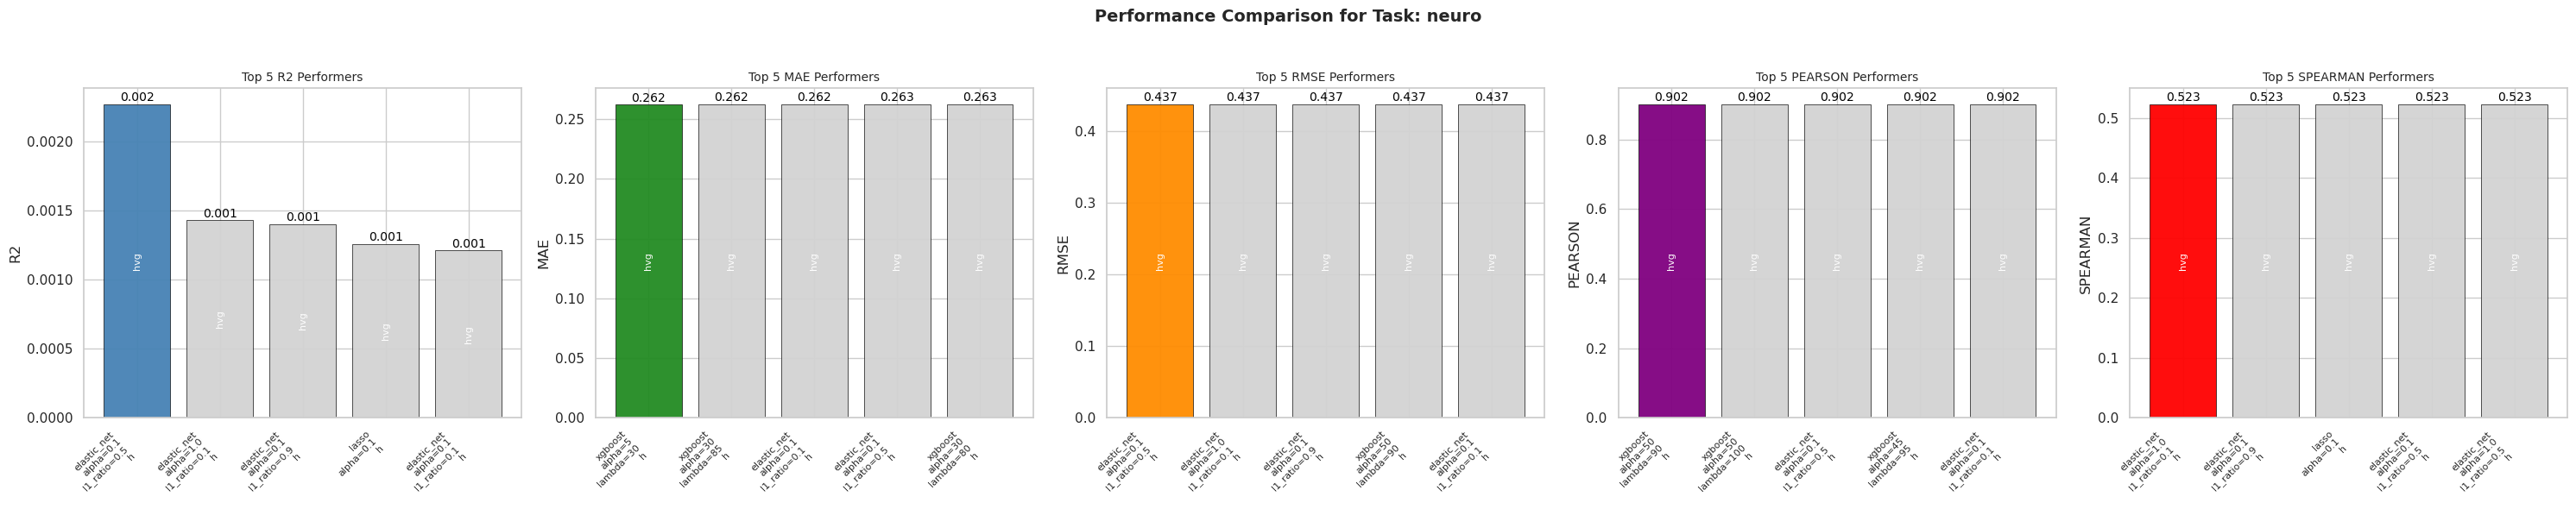

In [16]:
selected_task = task
num_top_models = 5
# Define metrics and their optimization direction
metrics = ['r2', 'mae', 'rmse', 'pearson', 'spearman']
best_direction = {'r2': 'max', 'mae': 'min', 'rmse': 'min', 'pearson': 'max', 'spearman': 'max'}
highlight_colors = {'r2': 'steelblue', 'mae': 'forestgreen', 'rmse': 'darkorange', 'pearson': 'purple', 'spearman': 'red'}
default_color = 'lightgray'
text_color = 'white'

# Mapping featsel to a short label for the x-axis
featsel_map = {
    'hvg': 'h',
    'hvg_svd': 'hs',
    'hvg_svd_graph': 'hsg',
    'svd': 's',
    'svd_graph': 'sg',
    'hvg_nomsi': 'hvg_nomsi'
}

def get_method_label(method_name, featsel, method_params):
    """
    Returns a multi-line label for the x-axis in the form:
    
      method_name
      key1=val1
      key2=val2
      ...
      featsel_short
    
    If no method_params are provided, the label consists of just the method_name
    on the first line and the shortened featsel on the second line.
    """
    # Use the short featsel for the x-axis label
    featsel_short = featsel_map.get(featsel, featsel)
    
    # Convert method_params from string to dict if needed
    if isinstance(method_params, str):
        method_params = eval(method_params)
        
    if not method_params or not isinstance(method_params, dict):
        return f"{method_name}\n{featsel_short}"
    
    # Create a list of parameter strings and keep only the first two pairs
    param_parts = [f"{k}={v}" for k, v in method_params.items()]
    param_parts = param_parts[:2]
    param_str = "\n".join(param_parts)
    
    # Return the multi-line label
    return f"{method_name}\n{param_str}\n{featsel_short}"

# Prepare a list of columns to select
columns_to_select = ['method_name', 'featsel']
if 'method_params' in df.columns:
    columns_to_select.append('method_params')

# Create a dictionary to store top performers for each metric
top_performers = {}
for metric in metrics:
    if metric in df.columns:
        if best_direction[metric] == 'max':
            top_indices = df[metric].nlargest(num_top_models).index
        else:
            top_indices = df[metric].nsmallest(num_top_models).index
        selected_columns = columns_to_select + [metric]
        top_performers[metric] = df.loc[top_indices, selected_columns]

# Create a subplot for each metric
num_metrics = len(metrics)
fig, axes = plt.subplots(1, num_metrics, figsize=(6 * num_metrics, 6), squeeze=False)
fig.suptitle(f"Performance Comparison for Task: {selected_task}", fontsize=14, fontweight='bold')

for i, metric in enumerate(metrics):
    ax = axes[0, i]
    if metric not in top_performers:
        continue

    top_df = top_performers[metric]
    method_labels = []
    original_featsel = []  # to annotate inside bars
    for _, row in top_df.iterrows():
        featsel_val = row['featsel']
        original_featsel.append(featsel_val)
        label = get_method_label(
            row['method_name'],
            featsel_val,
            row['method_params'] if 'method_params' in top_df.columns and pd.notna(row['method_params']) else None
        )
        method_labels.append(label)
    
    y_values = top_df[metric].values

    # Determine best value for highlighting
    if best_direction[metric] == 'max':
        overall_best_value = max(y_values)
    else:
        overall_best_value = min(y_values)
    colors = [highlight_colors[metric] if val == overall_best_value else default_color for val in y_values]

    bars = ax.bar(method_labels, y_values, color=colors, alpha=0.95, edgecolor='black', linewidth=0.5)

    # Annotate metric value above each bar
    for bar, value in zip(bars, y_values):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            value + (ax.get_ylim()[1] * 0.002),
            f"{value:.3f}",
            ha='center', va='bottom', fontsize=10, color='black'
        )
    # Annotate the original featsel inside each bar vertically
    for bar, featsel in zip(bars, original_featsel):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() / 2,
            featsel,
            ha='center', va='center', fontsize=8, color=text_color, rotation=90
        )

    ax.set_title(f"Top {num_top_models} {metric.upper()} Performers", fontsize=10)
    ax.set_ylabel(metric.upper())
    ax.set_xticks([bar.get_x() + bar.get_width() / 2 for bar in bars])
    ax.set_xticklabels(method_labels, rotation=45, ha='right', fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig(full_path, dpi=300, bbox_inches='tight')
# print(f"Saved plot for {selected_task}: {full_path}")
plt.show()


Top 5 Best performers per model used 

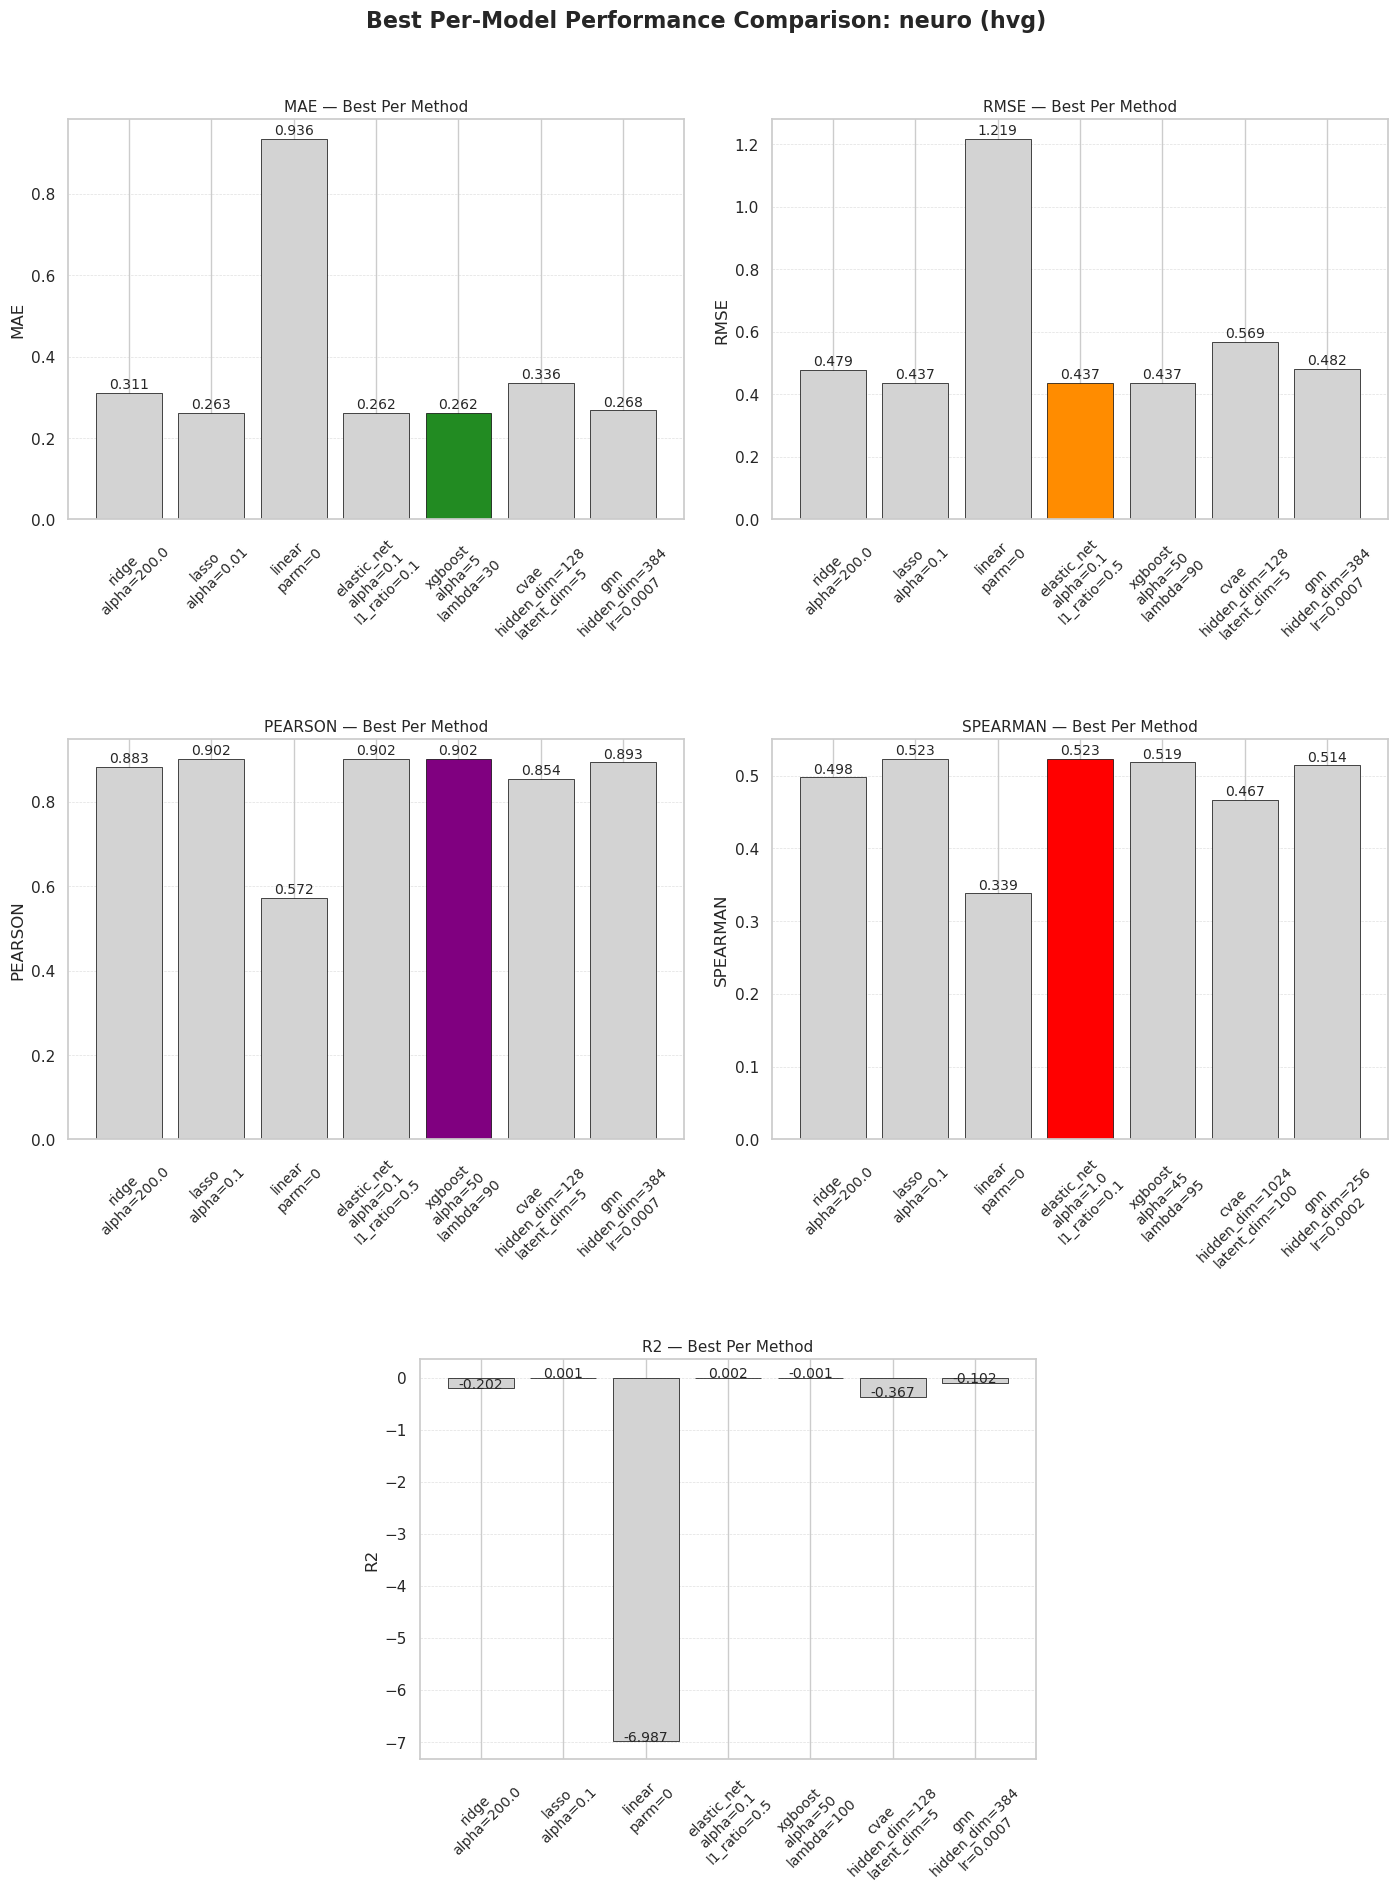

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec

# --- CONFIGURATION ---
selected_task = task
metrics = ['r2', 'mae', 'rmse', 'pearson', 'spearman']
best_direction = {'r2': 'max', 'mae': 'min', 'rmse': 'min', 'pearson': 'max', 'spearman': 'max'}
highlight_colors = {'r2': 'steelblue', 'mae': 'forestgreen', 'rmse': 'darkorange', 'pearson': 'purple', 'spearman': 'red'}
default_color = 'lightgray'
text_color = 'white'

featsel_map = {
    'hvg': 'hvg',
    'hvg_svd': 'hs',
    'hvg_svd_graph': 'hsg',
    'svd': 's',
    'svd_graph': 'sg',
    'hvg_nomsi': 'hvg_nomsi'
}

# --- LABEL FORMATTER ---
def get_method_label(method_name, featsel, method_params):
    featsel_short = featsel_map.get(featsel, featsel)
    if isinstance(method_params, str):
        method_params = eval(method_params)
    if not method_params or not isinstance(method_params, dict):
        return f"{method_name}\n{featsel_short}"
    param_parts = [f"{k}={v}" for k, v in method_params.items()]
    param_parts = param_parts[:2]
    param_str = "\n".join(param_parts)
    return f"{method_name}\n{param_str}"

# --- DATA PREP ---
df = df.dropna(subset=metrics)

best_performers_by_metric = {}
for metric in metrics:
    top_rows = []
    for model in df['method_name'].unique():
        model_df = df[df['method_name'] == model]
        if model_df.empty or metric not in model_df.columns:
            continue
        best_row = model_df.loc[model_df[metric].idxmax()] if best_direction[metric] == 'max' else model_df.loc[model_df[metric].idxmin()]
        top_rows.append(best_row)
    best_performers_by_metric[metric] = pd.DataFrame(top_rows)

# --- FIGURE & LAYOUT ---
fig = plt.figure(figsize=(22, 20))
plt.subplots_adjust(left=0.05, right=0.98, top=0.95, bottom=0.05)
plt.suptitle(f"Best Per-Model Performance Comparison: {selected_task} ({fs})",
             fontsize=16, fontweight='bold', y=0.975, x=0.34)  # centered title

# Metric groups per row
row1_metrics = ['mae', 'rmse']
row2_metrics = ['pearson', 'spearman']
row3_metrics = ['r2']

# Axes positions
w, h = 0.28, 0.20  # ← reduced height slightly
x_row_1 = [0.05, 0.37]
x_row_2 = [0.05, 0.37]
x_row_3 = [0.21]

y_row_1 = 0.72
y_row_2 = 0.41
y_row_3 = 0.10  # ← spread out spacing between rows

# --- PLOTTING FUNCTION ---
def plot_metric(ax, metric):
    top_df = best_performers_by_metric[metric]
    labels = [get_method_label(row['method_name'], row['featsel'], row['method_params']) for _, row in top_df.iterrows()]
    y_vals = top_df[metric].values
    best_val = max(y_vals) if best_direction[metric] == 'max' else min(y_vals)
    colors = [highlight_colors[metric] if val == best_val else default_color for val in y_vals]

    bars = ax.bar(labels, y_vals, color=colors, edgecolor='black', linewidth=0.5)
    for bar, val in zip(bars, y_vals):
        ax.text(bar.get_x() + bar.get_width() / 2, val + (ax.get_ylim()[1] * 0.01), f"{val:.3f}",
                ha='center', fontsize=10)

    ax.set_title(f"{metric.upper()} — Best Per Method", fontsize=11)
    ax.set_ylabel(metric.upper())
    ax.set_xticks([bar.get_x() + bar.get_width() / 2 for bar in bars])
    ax.set_xticklabels(labels, rotation=45, ha='center', fontsize=10)
    ax.set_facecolor("white")
    ax.set_axisbelow(True)
    ax.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.6)

# --- TOP ROW (MAE, RMSE) ---
for i, metric in enumerate(row1_metrics):
    ax = fig.add_axes([x_row_1[i], y_row_1, w, h])
    plot_metric(ax, metric)
    
# --- MIDDLE ROW (PEARSON, SPEARMAN) ---
for i, metric in enumerate(row2_metrics):
    ax = fig.add_axes([x_row_2[i], y_row_2, w, h])
    plot_metric(ax, metric)

# --- BOTTOM ROW (R2) ---
for i, metric in enumerate(row3_metrics):
    ax = fig.add_axes([x_row_3[i], y_row_3, w, h])
    plot_metric(ax, metric)

# --- Save ---
    plt.savefig(f"/lustre/groups/ml01/workspace/eirini/thesis_plots/viz/{selected_task}_{fs}_best_per_model_metrics.png", dpi=600, bbox_inches="tight")
plt.show()


Boxplots per model runs for all the metrics

In [11]:
df.head()

,rmse,mae,r2,pearson,spearman,task,method_name,featsel,method_params,hash
0,0.554643,0.435045,-2.621599,0.837399,0.706831,lipids,ridge,hvg,{'alpha': 1.0},a51cb27a8c
1,0.658927,0.516056,-4.107768,0.788696,0.656811,lipids,ridge,hvg,{'alpha': 0.1},ee5c68a518
2,0.327100,0.253298,-0.243606,0.935647,0.842883,lipids,ridge,hvg,{'alpha': 100.0},9057959eb0
3,0.680768,0.532901,-4.451549,0.778568,0.647076,lipids,ridge,hvg,{'alpha': 0.01},edeb306418
4,0.310650,0.239663,-0.120231,0.941771,0.855097,lipids,ridge,hvg,{'alpha': 200.0},0ad5fbe868


In [12]:
boxplots_df = df
# boxplots_df = df[~df["method_name"].isin(["linear", "ridge"])]


In [13]:
task
fs

'hvg'

/tmp/ipykernel_1431743/2735379615.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
/tmp/ipykernel_1431743/2735379615.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
/tmp/ipykernel_1431743/2735379615.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
/tmp/ipykernel_1431743/2735379615.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
/tmp/ipykernel_1431743/2735379615.py:55: UserWarning: set_ticklabels() shoul

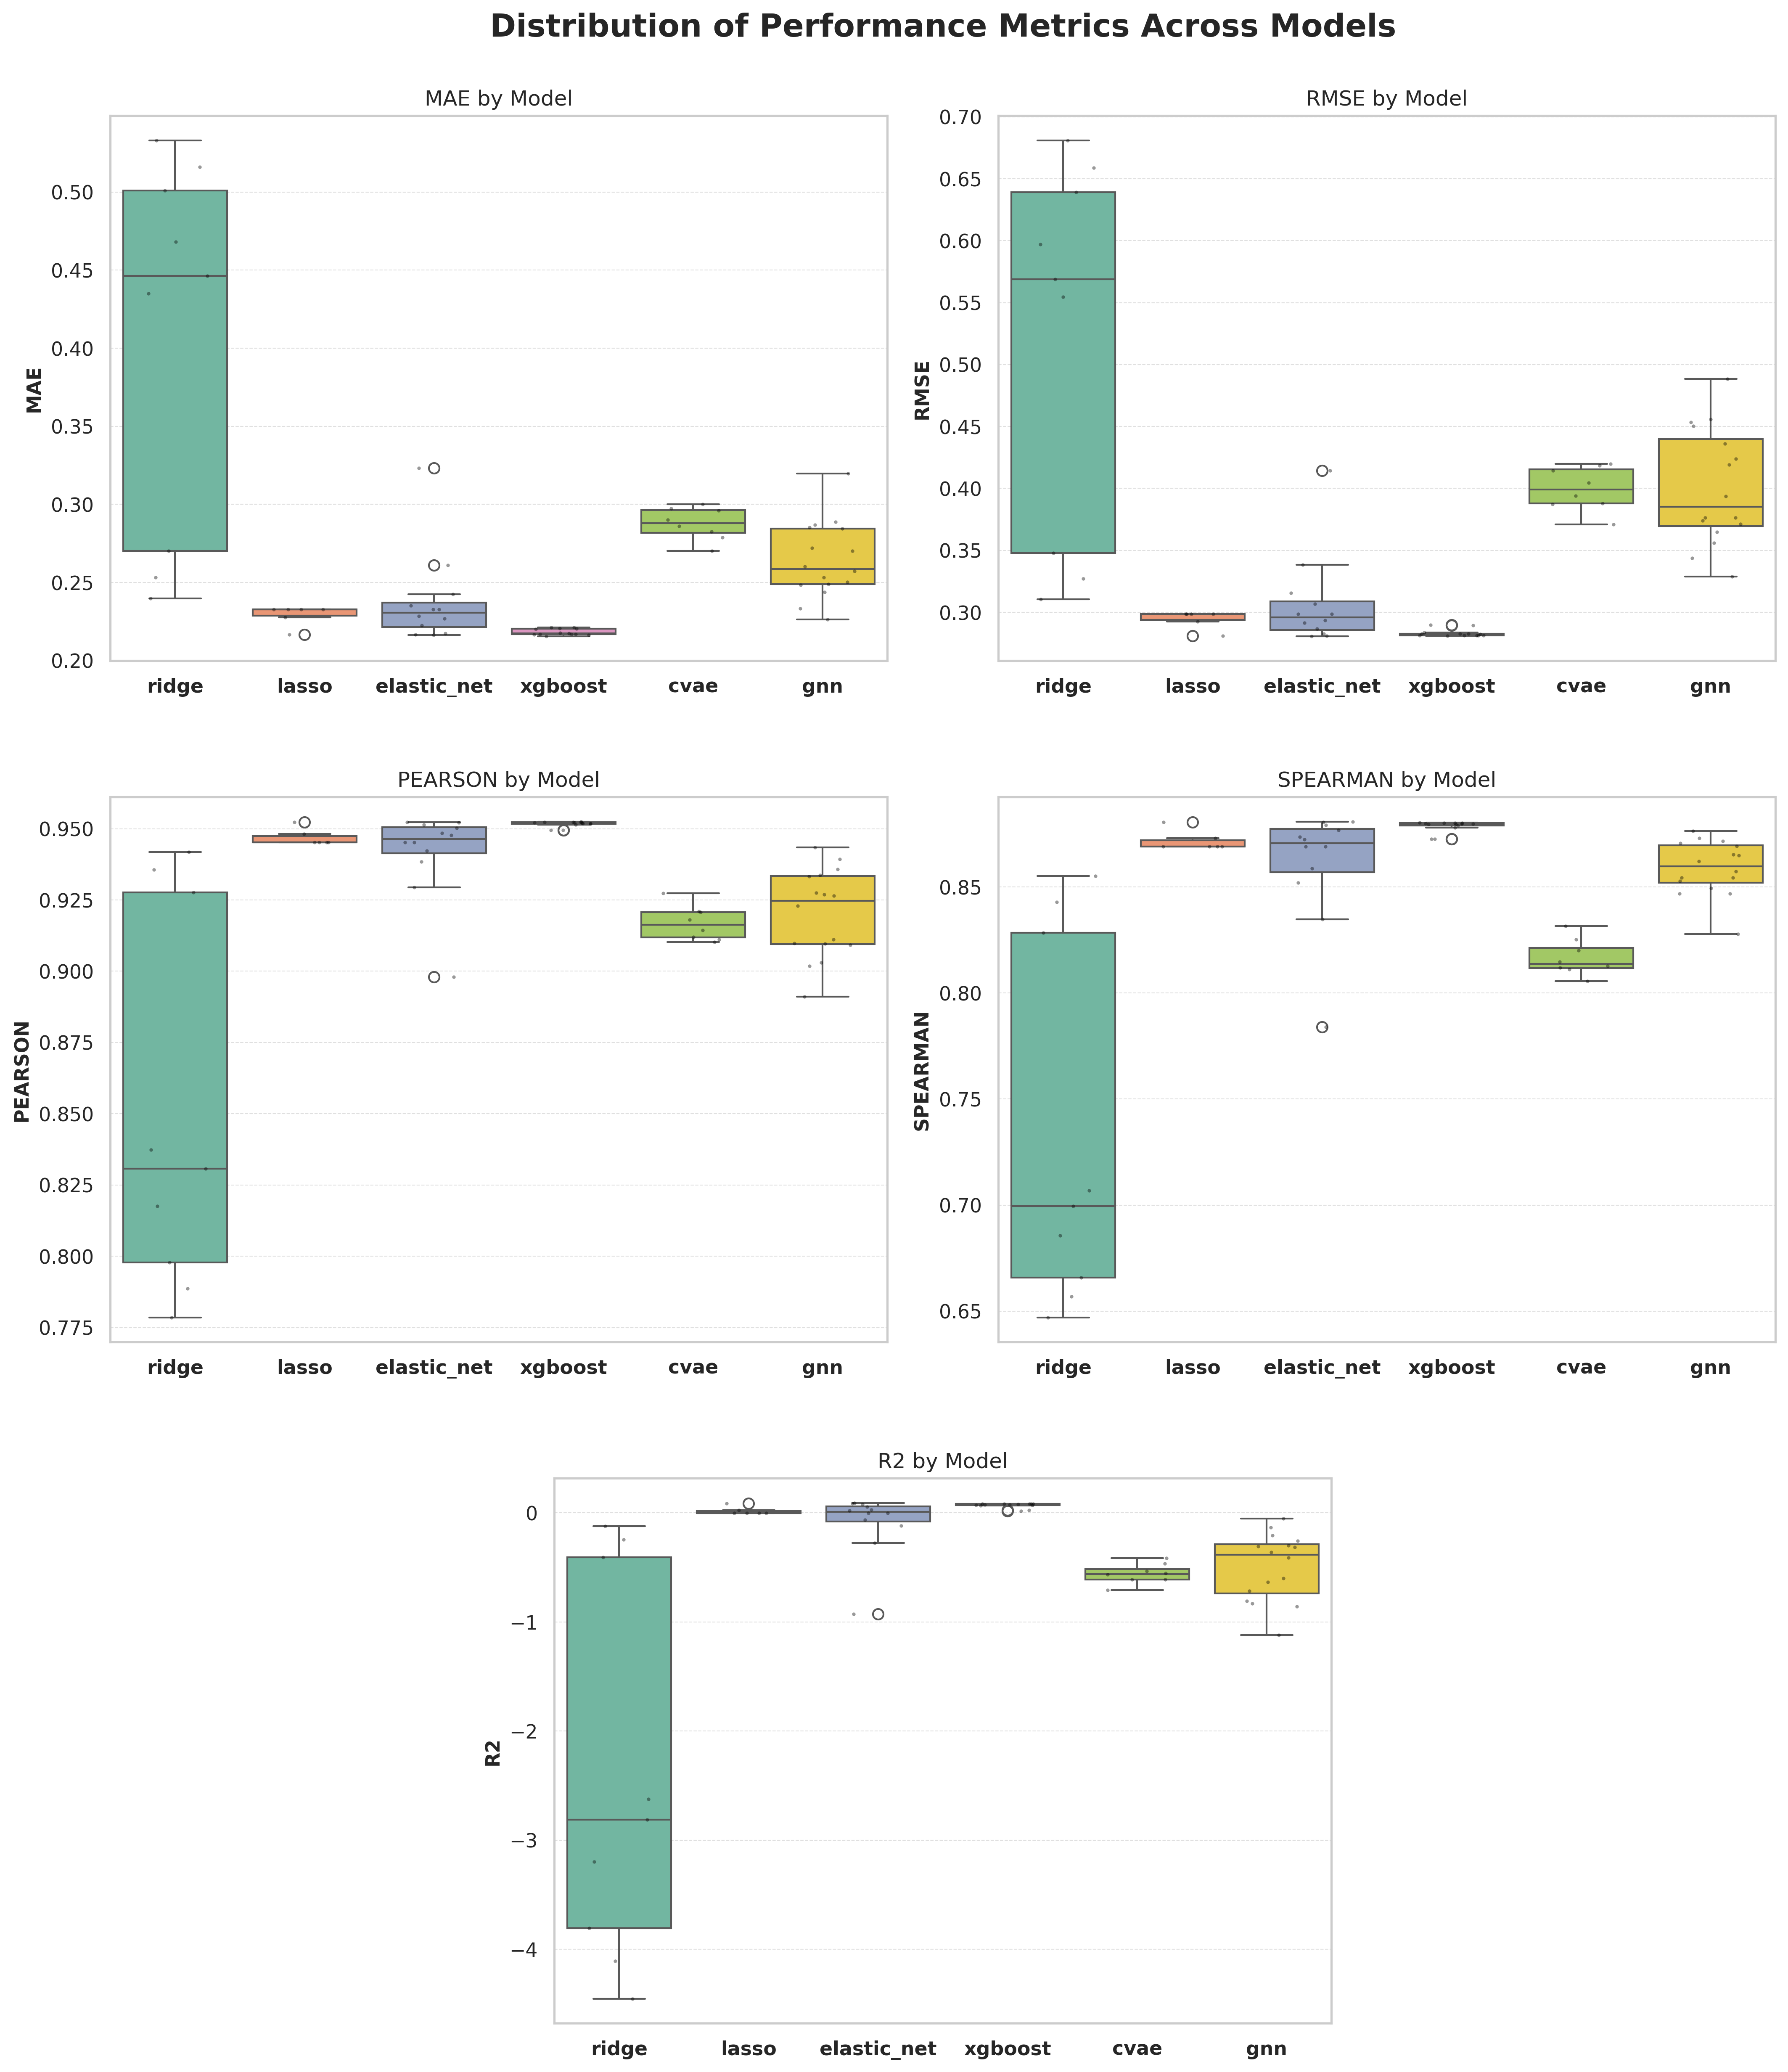

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Filter + Order ---
box_df = boxplots_df[~boxplots_df["method_name"].isin(["linear"])]
model_order = ['ridge', 'lasso', 'elastic_net', 'xgboost', 'cvae', 'gnn']
metrics = ['mae', 'rmse', 'pearson', 'spearman', 'r2']

# --- Layout config ---
fig = plt.figure(figsize=(22, 18), dpi=300)
plt.subplots_adjust(left=0.05, right=0.98, top=0.93, bottom=0.06)

# Axes positions for manual layout
positions = {
    'mae': (0.05, 0.66),
    'rmse': (0.37, 0.66),
    'pearson': (0.05, 0.36),
    'spearman': (0.37, 0.36),
    'r2': (0.21, 0.06),
}
w, h = 0.28, 0.24

# --- Plot ---
for metric in metrics:
    left, bottom = positions[metric]
    ax = fig.add_axes([left, bottom, w, h])

    sns.boxplot(
        data=box_df,
        x='method_name',
        y=metric,
        hue='method_name',
        ax=ax,
        order=model_order,
        palette='Set2',
        dodge=False,
        legend=False
    )
    sns.stripplot(
        data=box_df,
        x='method_name',
        y=metric,
        ax=ax,
        order=model_order,
        color='black',
        size=2,
        jitter=0.25,
        alpha=0.4
    )

    ax.set_title(f"{metric.upper()} by Model", fontsize=12)
    ax.set_xlabel("")  # removes x-axis label
    ax.set_ylabel(metric.upper(), fontsize=11,fontweight='bold')
    ax.tick_params(axis='x',  labelsize=11)
    ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
    ax.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.6)

# --- Centered Title (calculated visually across top two subplots) ---
# Calculate center between 'mae' (0.05) and 'rmse' (0.37) with width w = 0.28
left_1 = 0.05
left_2 = 0.37
center = (left_1 + left_2 + w) / 2

# --- Centered Title (closer to plots) ---
fig.text(center, 0.935, "Distribution of Performance Metrics Across Models",
         ha='center', fontsize=18, fontweight='bold')

plt.savefig(f"/lustre/groups/ml01/workspace/eirini/thesis_plots/viz/{task}_{fs}_metric_boxplots.png",
            dpi=600, bbox_inches="tight")

plt.show()
